In [1]:
from ip_geo2 import *

/home/jsaxon/anaconda3/envs/aws/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### IP Geolocation databases and functions.

In [2]:
import maxminddb as mmdb
import IP2Location as ip2loc

geolite   = mmdb.open_database('../data/geolite2.mmdb')

ip2loc_v4 = ip2loc.IP2Location("../data/ip2loc_ipv4_db5.bin")
ip2loc_v6 = ip2loc.IP2Location("../data/ip2loc_ipv6_db5.bin")


def get_locations(x):
    
    loc = {"ip_address" : x, 
           "mm_lat" : np.nan, "mm_lon" : np.nan, 
           "mm_acc" : np.nan, "mm_loc" : np.nan,
           "ip2loc_lat" : np.nan, "ip2loc_lon" : np.nan,
           "ip2loc_loc" : np.nan}
    
    mm_ret = geolite.get(x)
    if mm_ret is not None and "location" in mm_ret:
        mm_loc = mm_ret["location"]
        loc["mm_lat"] = mm_loc["latitude"]
        loc["mm_lon"] = mm_loc["longitude"]
        loc["mm_acc"] = mm_loc["accuracy_radius"]
        loc["mm_loc"] = Point([loc["mm_lon"], loc["mm_lat"]])


    if "." in x: ip2loc_ret = ip2loc_v4.get_all(x)
    else:        ip2loc_ret = ip2loc_v6.get_all(x)
        
    if ip2loc_ret.country_short != "-":
        loc["ip2loc_lat"] = ip2loc_ret.latitude
        loc["ip2loc_lon"] = ip2loc_ret.longitude
        loc["ip2loc_loc"] = Point([loc["ip2loc_lon"], loc["ip2loc_lat"]])
        
    return pd.Series(loc)


### ASNs

In [3]:
from pyasn import pyasn

asndb = pyasn("data/ipasn_20200811.dat.gz")

### Haversine to avoid projecting over long distances.

In [4]:
def haversine(x1, y1, x2, y2):
    
    x1 = np.deg2rad(x1)
    y1 = np.deg2rad(y1)
    x2 = np.deg2rad(x2)
    y2 = np.deg2rad(y2)
    
    hav = 2 * np.arcsin(np.sqrt(np.sin((x1 - x2) / 2)**2 + np.cos(x1) * np.cos(x2) * np.sin((y1 - y2) / 2)**2))
    
    hav[np.isnan(hav)] = np.inf
    
    hav_dist = hav * 6371
    
    return hav_dist


### Plotting Macro.

In [5]:
import matplotlib.ticker as mticker

colors = {
    "mm" : "#128BE9", "ip" : "#0C3B7C",
    "comcast" : "#000000", "verizon" : "#cf1c1a", 
    "att" : "#1391d2", "sprint" : "#fdbf0e", "tmobile" : "#db006c"
}

labels = {
    "mm" : "MaxMind", "ip" : "IP2Location",
    "comcast" : "Comcast", "verizon" : "Verizon", 
    "att" : "AT&T", "sprint" : "Sprint", "tmobile" : "T-Mobile"
}

bins = list(np.arange(0, 10, 0.01).round(2)) + \
       list(np.arange(10, 100, 0.1).round(1)) + \
       list(range(100, 1000, 1)) + list(range(1000, 20000, 10))

args = {"cumulative" : True, "density" : 1, "bins" : bins, "histtype" : "step", "lw" : 1.5}

leg_args = {"loc" : "lower right", "facecolor" : "w", "framealpha" : 1, "frameon" : True}

dots = (0, (1, 0)), (0, (2, 5)), (2, (2, 2))

def get_figs(kv, leg = True, cmap = None, ax = None, save = ""):

    if not ax: fig, ax = plt.subplots()

    if cmap: cmap = plt.get_cmap(cmap)

    for ki, (k, v) in enumerate(kv.items()):
        
        label = k    if k not in labels else labels[k]
        ls    = "-"  if len(kv) > 3     else dots[ki]
        
        color = None
        if k in colors: color = colors[k]
        if cmap:
            color = "#{:02X}{:02X}{:02X}".format(*[int(v*255) for v in cmap(ki/(len(kv)-1))])
        
        v.hist(label = label, color = color, ls = ls, ax = ax, **args)
        

    if leg: ax.legend(**leg_args)
        
    ax.set_xlim(1, 3000)
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.set_xlabel("GPS to Geolocated IP [km]")
    ax.set_ylabel("Cumulative Density")
    
    if save: ax.figure.savefig("figs/{}.pdf".format(save))
    if save: ax.figure.savefig("figs/{}.png".format(save), dpi = 300)
    
    return ax

### Analysis...

#### Get the data...

In [6]:
chicago_ip = get_data()
chicago_ip.rename(columns = {"latitude" : "lat", "longitude" : "lon"}, inplace = True)

15643814 2.002408192


A few are non-IANA-special CIDR are missing when using the pyasn approach.  Most of these are DoD addresses, but some are T-Mobile.  They are not dominantly IPv4 or IPv6.

#### Extract the IP addresses, so that we only do this lookup once.

In [7]:
unique_ip = chicago_ip.ip_address.sort_values().drop_duplicates().reset_index(drop = True)

ip_locations = unique_ip.progress_apply(get_locations)

ip_locations["mm_ip_dist"] = haversine(ip_locations.ip2loc_lat, ip_locations.ip2loc_lon,
                                       ip_locations.mm_lat,     ip_locations.mm_lon)

100%|██████████| 338953/338953 [04:33<00:00, 1241.36it/s]


#### Merge them back on, and calulate the distances to the GPS locations.

In [8]:
chicago_ip = chicago_ip.merge(ip_locations)

chicago_ip["gps_ip_dist"] = haversine(chicago_ip.lat,        chicago_ip.lon,
                                      chicago_ip.ip2loc_lat, chicago_ip.ip2loc_lon)

chicago_ip["gps_mm_dist"] = haversine(chicago_ip.lat,    chicago_ip.lon,
                                      chicago_ip.mm_lat, chicago_ip.mm_lon)

chicago_ip["C"] = 1

In short, MaxMind is better.

In [9]:
(chicago_ip.query("DBA == 'Comcast'").filter(regex = "gps.*dist", axis = 1) < 50).mean()

gps_ip_dist    0.895122
gps_mm_dist    0.974300
dtype: float64

### First-Blush Accuracy:

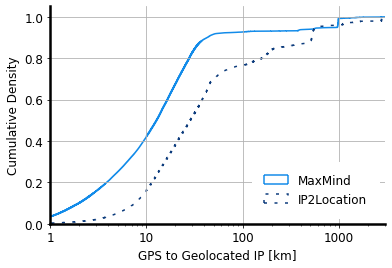

In [10]:
get_figs({"mm" : chicago_ip.gps_mm_dist, "ip" : chicago_ip.gps_ip_dist}, save = "acc_mm_v_ip2loc")

### Accuracy by Carrier

These are the big boys:

In [11]:
chicago_ip.DBA.value_counts().head(10)

T-Mobile    4606423
ATT         3119312
Comcast     2669211
Sprint      2301770
Verizon     1677817
IANA         631780
RCN          196579
WOW          126597
PSINet        22514
SPC           20133
Name: DBA, dtype: int64

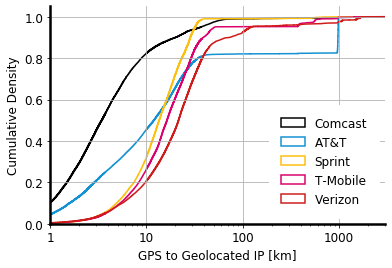

In [12]:
to_key = lambda x: x.lower().replace("-", "")

get_figs({to_key(k) : chicago_ip.query("DBA == '{}'".format(k)).gps_mm_dist
         for k in ["Comcast", "ATT", "Sprint", "T-Mobile", "Verizon"]}, 
         save = "acc_by_carrier")

### Identifying the Outliers

MaxMind's default location points to [Cheney Reservoir, Kansas](https://splinternews.com/this-is-the-new-digital-center-of-the-united-states-1793856143).  This seems, in particular, to affect the AT&T points, nearly 18% of which are geocoded there.

In [13]:
chicago_ip.query("(DBA == 'ATT') & (950 < gps_mm_dist) & (gps_mm_dist < 990)")[["mm_lat", "mm_lon"]].median()

mm_lat    37.751
mm_lon   -97.822
dtype: float64

Pretty much the entire 107.77.173.0 subnet is coded there (does it show up in NYC, too)?  Note that 107.64.0.0/10 is [allocated](https://whois.arin.net/rest/net/NET-107-64-0-0-1/pft?s=107.77.173.0) to AT&T Mobility LLC, whereas the most common _really_ close ones (distance < 1 km) are allocated to AT&T Corp, e.g., [70.235.128.0](https://whois.arin.net/rest/net/NET-70-232-128-0-1/pft?s=70.235.128.0).

In [14]:
chicago_ip.query("(DBA == 'ATT') & (950 < gps_mm_dist) & (gps_mm_dist < 990)").subnet.value_counts().head(5)

107.77.173.0       511846
2600:387:b::         6688
107.77.172.0         1509
2602:306:bc1c::       885
2602:30a:2e78::       603
Name: subnet, dtype: int64

In [15]:
chicago_ip.query("(DBA == 'ATT') & (950 < gps_mm_dist) & (gps_mm_dist < 990)").ip_address.value_counts().head(5)

107.77.173.44    9283
107.77.173.31    9062
107.77.173.33    8988
107.77.173.62    8903
107.77.173.37    8861
Name: ip_address, dtype: int64

In [16]:
chicago_ip.query("(DBA == 'ATT') & (gps_mm_dist < 1)").subnet.value_counts().head(5) ## All AT&T Corp.

70.235.128.0     2292
162.233.155.0    1831
162.224.229.0    1614
162.237.30.0     1571
99.145.53.0      1454
Name: subnet, dtype: int64

#### Verizon 
For Verizon, the step-ups are less clear.  There is a big increase between 50 and 100 km, but while there are a few locations with a very large number of points, they do not appear to be particularly special.  For instance, the most common location, at (42.2571, -88.8535) has 30 thousand points and is coded down to the city (Belvidere, IL).  These also do not appear to be issues with the IP addresses registered in the GPS data, which are fairly diverse at that point (i.e., it is not just one user making all the trouble).  I guess that these are just other "sink" locations, as show up in the GPS data as well.

In [17]:
chicago_ip.query("(DBA == 'Verizon') & (50 < gps_mm_dist) & (gps_mm_dist < 100)")\
          .mm_loc.apply(lambda x : x.coords[0]).value_counts().head(3)

(-88.8535, 42.2571)    30612
(-88.3781, 42.0305)    28381
(-88.1414, 42.1597)    10711
Name: mm_loc, dtype: int64

In [18]:
chicago_ip.query("(DBA == 'Verizon') & (mm_lat == 42.2571)").ip_address.value_counts().head(5)

174.192.82.120    339
174.192.86.227    225
174.192.81.98     191
174.192.81.89     182
174.192.81.147    163
Name: ip_address, dtype: int64

In [19]:
chicago_ip.query("(DBA == 'Verizon') & (mm_lat == 42.2571)").identifier.value_counts().head(5)

0025165e-c5ea-4441-9ed8-0cf08b1c0245    328
377b0b02-d55f-4a35-a8b3-2b0d5d0e68c8    294
cc32f007-b0e8-4749-ae4e-6ef59bb9f7b1    273
65571841-303f-4902-8cf4-1b218277d3c9    175
0ecfd3ed-e28d-4e68-8343-32fd0443dfd7    158
Name: identifier, dtype: int64

#### T-Mobile
There is a large number of points, about 380 km from Chicago, geocoded to Detroit (metro pop 4.3M).  The first of these coordinates is along Detroit's northern edge, far from its "geographic center."  There's another substantial "rise" at 560 km from Chicago, corresponding to Minneapolis (metro pop 3.6M).  Indianapolis (≈265 km, 2.0M metro) and St Louis (≈420 km, 2.8M metro) see no notable jumps -- perhaps at least in part relating to their smaller populations (smaller infrastructures, and fewer people travelling there).

In [20]:
chicago_ip.query("(DBA == 'T-Mobile') & (360 < gps_mm_dist) & (gps_mm_dist < 400)")\
          .mm_loc.apply(lambda x : x.coords[0]).value_counts().head(3)

(-83.1522, 42.4257)    41566
(-83.1329, 42.3673)    24817
(-83.2514, 42.4261)      758
Name: mm_loc, dtype: int64

In [21]:
chicago_ip.query("(DBA == 'T-Mobile') & (500 < gps_mm_dist) & (gps_mm_dist < 600)")\
          .mm_loc.apply(lambda x : x.coords[0]).value_counts().head(3)

(-93.2188, 44.9402)    67064
(-85.1321, 37.8395)     2691
(-81.5746, 41.4781)     1002
Name: mm_loc, dtype: int64

Similarly, if we keep to Chicago, the T-Mobile points are geolocated to just a few locations

In [22]:
tmobile_chicago = chicago_ip.query("(DBA == 'T-Mobile') & (gps_mm_dist < 50)")
tmobile_chicago.mm_loc.apply(lambda x : x.coords[0]).value_counts().head(3) / tmobile_chicago.shape[0]

(-87.7108, 41.9984)    0.657451
(-87.6736, 41.8502)    0.313198
(-87.7613, 41.8883)    0.003866
Name: mm_loc, dtype: float64

### MaxMind Claimed Accuracy

In [23]:
chicago_ip.mm_acc.value_counts().sort_index()

1.0       1187904
5.0       2419421
10.0       219589
20.0       165347
50.0       871074
100.0     1353295
200.0     1889398
500.0     6216291
1000.0     689648
Name: mm_acc, dtype: int64

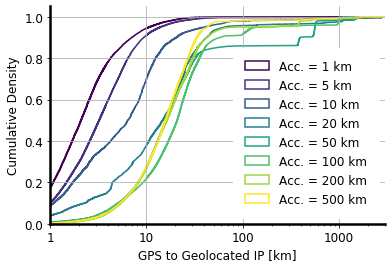

In [24]:
get_figs({"Acc. = {:d} km".format(k) : chicago_ip.query("mm_acc == {}".format(k)).gps_mm_dist
          for k in [1, 5, 10, 20, 50, 100, 200, 500]}, 
         cmap = "viridis", save = "acc_by_mm_acc")

They are clearly aware of the different structures, by carrier.

In [25]:
big5 = ["T-Mobile", "ATT", "Comcast", "Sprint", "Verizon"]

mm_acc_cuts = chicago_ip.query("DBA in @big5").groupby(["DBA", "mm_acc"]).mm_acc.count() / \
              chicago_ip.groupby("DBA").mm_acc.count()

mm_acc_cuts.unstack().fillna(0).round(2)

mm_acc,1.0,5.0,10.0,20.0,50.0,100.0,200.0,500.0,1000.0
DBA,,,,,,,,,
ATT,0.12,0.20,0.02,0.01,0.01,0.01,0.00,0.47,0.18
Comcast,0.24,0.61,0.05,0.02,0.02,0.06,0.00,0.00,0.01
Sprint,0.00,0.00,0.00,0.00,0.24,0.01,0.60,0.15,0.00
T-Mobile,0.00,0.00,0.00,0.01,0.04,0.01,0.01,0.93,0.00
Verizon,0.00,0.00,0.00,0.00,0.03,0.66,0.27,0.03,0.00


### MaxMind vs IP2Location, by Carrier

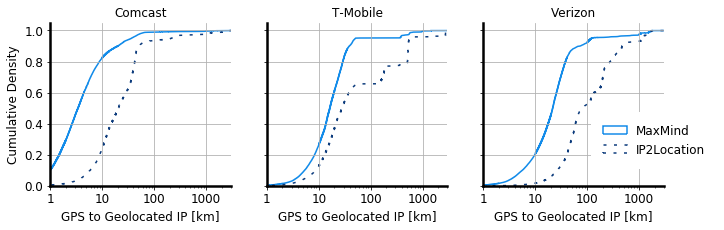

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (11, 3), sharey = True)

for i, c in enumerate(["Comcast", "T-Mobile", "Verizon"]):
    get_figs({"mm" : chicago_ip.query("DBA == '{}'".format(c)).gps_mm_dist, 
              "ip" : chicago_ip.query("DBA == '{}'".format(c)).gps_ip_dist}, 
             ax = ax[i], leg = False)
    
    ax[i].set_title(c)
    if i: ax[i].set_ylabel("")
    
leg3_args = {"bbox_to_anchor" : (0.56, 0.07), "loc" : 'lower left', "frameon" : True}

ax[2].legend(**leg3_args)

fig.savefig("figs/acc_by_carrier_facet.pdf")

### A Typology of Clusters from the Geographic Extent

In [27]:
chicago_ip.dropna()[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     81.591110
gps_ip_dist    174.182252
dtype: float64

In [28]:
chicago_ip.query("DBA == 'T-Mobile'")[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     46.287278
gps_ip_dist    237.443932
dtype: float64

In [29]:
chicago_ip.query("DBA == 'Comcast'")[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist    16.835730
gps_ip_dist    80.885994
dtype: float64

But if we choose some of the geographically localized clusters from Comcast -- with multiple addresses per subnet! -- the accuracies are way, way better.

In [30]:
localized_subnets = ["98.222.252.0", "98.227.229.0", "73.209.252.0", "50.200.11.0", "76.16.225.0", 
                     "98.206.197.0", "24.14.202.0",  "24.1.42.0",    "24.1.164.0", "67.175.34.0"]

chicago_ip["localized_comcast"] = chicago_ip.subnet.isin(localized_subnets)
chicago_ip.query("localized_comcast").groupby("subnet")[["gps_mm_dist", "gps_ip_dist"]].mean()

,gps_mm_dist,gps_ip_dist
subnet,,
24.1.164.0,5.055042,39.773690
24.1.42.0,5.025674,40.221427
24.14.202.0,5.438732,6.512521
50.200.11.0,3.518607,15.670083
67.175.34.0,3.589099,5.256208
73.209.252.0,4.809835,14.851489
76.16.225.0,4.197543,35.773340
98.206.197.0,4.607351,15.841912
98.222.252.0,2.615974,27.405916


### What about Unacast as a data source?

What fraction are RIPE, LACNIC, APNIC, AfriNIC?  Really low....

In [31]:
foreign_nic = ["RIPE", "AFRINIC", "APNIC", "LACNIC"]

chicago_ip.query("DBA in @foreign_nic").groupby("DBA").DBA.count() / chicago_ip.DBA.count()

DBA
AFRINIC    0.000060
APNIC      0.000107
LACNIC     0.000256
RIPE       0.000616
Name: DBA, dtype: float64

However, there is a modest fraction that from local networks, loopback etc -- 

In [32]:
chicago_ip.ip_address.str.startswith("10.").mean()

0.009469749512491007

In [33]:
chicago_ip.DBA.str.startswith("IANA").mean()

0.040385472940493015

Do we do any better on Comcast accuracies by restricting ourselves to night pings with long durations, etc.?

In [34]:
localized_comcast = chicago_ip.query("localized_comcast")

In [35]:
chicago_ip.classification.value_counts()

TRAVEL                  3865947
AREA_DWELL              3861169
SHORT_AREA_DWELL        2736690
LONG_AREA_DWELL         2322802
POTENTIAL_AREA_DWELL    1962445
PING                     889592
LARGE_VARIANCE             4753
MOVING                      362
SPLIT                        54
Name: classification, dtype: int64

In [36]:
localized_comcast.groupby("classification").classification.count()

classification
AREA_DWELL              3882
LONG_AREA_DWELL         2267
PING                     526
POTENTIAL_AREA_DWELL    1360
SHORT_AREA_DWELL         737
TRAVEL                   814
Name: classification, dtype: int64

In [37]:
localized_comcast[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     4.053969
gps_ip_dist    21.740885
dtype: float64

In [38]:
localized_comcast.query("classification != 'TRAVEL'")[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     3.987938
gps_ip_dist    21.859261
dtype: float64

In [39]:
dwell_types = ["LONG_AREA_DWELL", "SHORT_AREA_DWELL"]

localized_comcast.query("classification in @dwell_types")[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     4.424768
gps_ip_dist    23.253168
dtype: float64

In [40]:
localized_comcast.query("classification == 'LONG_AREA_DWELL'")[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     4.729671
gps_ip_dist    21.622395
dtype: float64

In [41]:
localized_comcast.query("night > 0")[["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     5.307938
gps_ip_dist    21.023540
dtype: float64

Now what about with things night-time or home activity?

In [42]:
chicago_ip.query("DBA == 'Comcast'")[["localized_comcast", "night", "out_of_home"]].corr()

,localized_comcast,night,out_of_home
localized_comcast,1.000000,-0.000869,-0.003488
night,-0.000869,1.000000,-0.306792
out_of_home,-0.003488,-0.306792,1.000000


In [43]:
localized_comcast.query("(classification == 'LONG_AREA_DWELL') & (out_of_home == 0) & (night > 0)")\
          [["gps_mm_dist", "gps_ip_dist"]].mean()

gps_mm_dist     5.410889
gps_ip_dist    21.153913
dtype: float64

Short dwells and single pings are the best-localized WRT the MaxMind data -- these have less ambiguity in which IP addresss is associated to the cluster.

In [44]:
accuracy_by_class = chicago_ip.query("localized_comcast").groupby("classification")\
                              [["gps_mm_dist", "gps_ip_dist"]].mean()

accuracy_by_class = accuracy_by_class.round(2).sort_values("gps_mm_dist")

accuracy_by_class.index = accuracy_by_class.index.str.title().str.replace("_", " ")
accuracy_by_class

,gps_mm_dist,gps_ip_dist
classification,,
Area Dwell,3.37,20.78
Short Area Dwell,3.49,28.27
Ping,4.11,22.71
Long Area Dwell,4.73,21.62
Potential Area Dwell,4.75,21.53
Travel,4.77,20.47


### To-do
* Comparison of Chicago with NYC (prep for LA, WV) -- **refactor the code**.
* Distance scale (diameter or √A) of /24, CIDR, or AS (after 90% of nearest?)
* Compare paid versions of MaxMind ([\$48 / month](https://www.maxmind.com/en/geoip2-city) for North America) and IP2Location ([\$349 / year](https://www.ip2location.com/buy-online) for DB5... why anyone would pay another \\$150 for the ISP lookup is nonsense!  possibly interesting is their NetSpeed -- cable/fiber/mobile/dial-up -- but unlikely reliable and pretty expensive -- \\$1500+).